In [1]:
from utils.imports import *

Using TensorFlow backend.


In [2]:
model_paths = PATH['model_paths']
data_path = PATH['model_train']

In [3]:
model_fenge_path=model_paths + 'final_model/final_fenge.h5'
model_fenge = load_model(model_fenge_path, custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})

In [4]:
lungs = [x for x in sorted(os.listdir(data_path + 'lung/')) if x != '.DS_Store']
nods = [x for x in sorted(os.listdir(data_path + 'nodule/')) if x != '.DS_Store']
lung_100 = sorted(np.random.choice(lungs,100))

In [5]:
model_fenge.get_config() 

{'input_layers': [[u'input_1', 0, 0]],
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 1, 512, 512),
    'dtype': u'float32',
    'name': u'input_1',
    'sparse': False},
   'inbound_nodes': [],
   'name': u'input_1'},
  {'class_name': 'Conv2D',
   'config': {'activation': 'elu',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'data_format': u'channels_first',
    'dilation_rate': (1, 1),
    'filters': 32,
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'distribution': u'uniform',
      'mode': u'fan_avg',
      'scale': 1.0,
      'seed': None}},
    'kernel_regularizer': None,
    'kernel_size': (3, 3),
    'name': u'conv2d_1',
    'padding': u'same',
    'strides': (1, 1),
    'trainable': True,
    'use_bias': True},
   'inbound_nodes': [[[u'input_1', 0, 0, {}]]],
   'name': u'

### 模型预测结果与GroundTruth的相似度应越高越好，满值为1
#### -肺部掩模：加在预测前后都明显降低准确率
#### -预测结果门限：0.95，在实际检测中，不加门限的查出的ROI数量更少
#### -开运算：5和3没太大差别，3与不加open稍好0.01%，总0.11%

- 06072;28.292984%
- 06073;28.292829%
- 06082;28.292829%
- 06083;28.292829%

In [6]:
simule(data_path,model_fenge,lung_100)

100%|██████████| 100/100 [00:27<00:00,  3.95it/s]

分割的相似度是：0.006473%


In [16]:
for scan in tqdm(lung_100):
        patient_id = scan.split('/')[-1][:-4]
        img = cv2.imread(data_path + 'lung/' + scan,cv2.IMREAD_GRAYSCALE)   
        seg_img, overlap = helpers.get_segmented_lungs(img.copy()*255)
        mask = cv2.imread(data_path + 'nodule/' + scan[:-5] + 'm.png',cv2.IMREAD_GRAYSCALE).astype(int) 
        
        
        #img = skimage.morphology.binary_opening(np.squeeze(img), np.ones([2,2])) 
        img = np.expand_dims(img,0)
        img = np.expand_dims(img,0)   
        p = model_fenge.predict(img)

        p = np.squeeze(p)
        
        overlap = skimage.morphology.binary_opening(np.squeeze(overlap), np.ones([5,5]))
        p=p*overlap

100%|██████████| 100/100 [00:23<00:00,  4.32it/s]


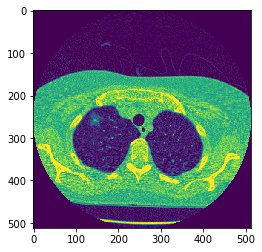

In [17]:
%matplotlib inline
plt.imshow(np.squeeze(img))

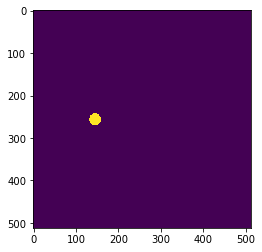

In [18]:
plt.imshow(np.squeeze(mask))

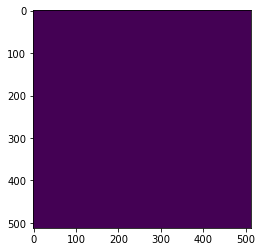

In [19]:
plt.imshow(np.squeeze(p))

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

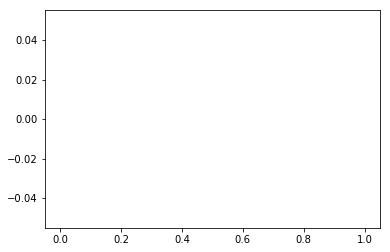

In [20]:
plt.hist(np.squeeze(p[p>0.2]).tolist())

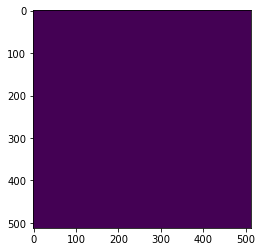

In [21]:
s=p.copy()
s[s==1]=int(1)
s[s!=1]=int(0)
s=np.squeeze(s)
s = skimage.morphology.binary_opening(s, np.ones([3,3]))
plt.imshow(s)

In [22]:
mean=0.0

mean += dice_coef_np(mask,s)

In [23]:
mean

6.386878796201084e-06

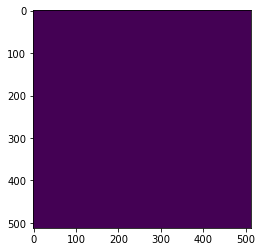

In [30]:
plt.imshow(np.squeeze(overlap*255))